## 富士山下山問題

勾配降下法は山や谷を下ることに例えられます。富士山の標高データを **最小化したい目的関数**に見立てて、富士山からの下山プログラムを作成することで勾配降下法を学びます。

## 富士山から下る

### 標高データの取得

標高データはcsvファイルを配布します。以下のコードで読み込むことができます。

In [1]:
import numpy as np
csv_path = "mtfuji_data.csv" # ファイル名（パス）を指定する
np.set_printoptions(suppress=True) # 指数表示の禁止を設定する
fuji = np.loadtxt(csv_path, delimiter=",", skiprows=1)
print(fuji)
print(fuji.shape)

[[    0.          35.134141   139.132082     0.           0.      ]
 [    1.          35.135826   139.129202     0.         322.      ]
 [    2.          35.13751    139.126322     0.         644.      ]
 ...
 [  297.          35.631284   138.271368  1973.99     95698.      ]
 [  298.          35.632947   138.268452  1841.36     96020.      ]
 [  299.          35.63461    138.265536  1725.8      96343.      ]]
(300, 5)


左から順番に「その地点の番号」「緯度」「経度」「標高」「地点0からの距離」となっています。標高と距離の単位はメートルです。300地点のデータです。

今回使用するデータは国土地理院の電子地形図の断面図機能を使用し取得しました。相模湾から富士山頂上付近を通り南アルプス方面へと向かう線上300地点の標高データです。

### 【問題1】データの可視化
Matplotlibを使い標高データを可視化してください。横軸に「その地点の番号」、縦軸に「標高」を設定すれば、富士山の断面図が描けます。

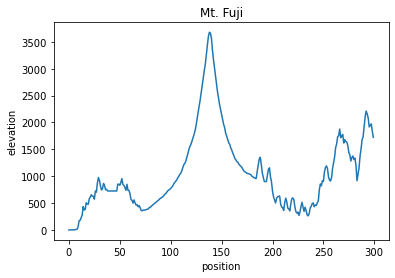

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.xlabel("position")
plt.ylabel("elevation")
plt.title("Mt. Fuji")
position = fuji[:,0]
peak = fuji[:,3]
plt.plot(position, peak)
plt.show()
#print(position)
#print(peak)

この断面図を見れば低い場所はすぐに分かりますが、今回は暗闇の中で足元の勾配のみが知れるという状況を想像します。

### 【問題2】ある地点の勾配を計算する関数を作成

「二次元配列と勾配問題」では各地点での勾配を最初に求めました。しかし、暗闇の富士山を想像すると、知ることができるのは今いる地点の勾配だけです。


「今いる地点の番号」と「今いる隣の地点の番号（今いる地点の番号-1）」の関係による勾配を求める関数を作成してください。


勾配は以下の式で求まりましたが、このデータでは「標高」がy、「その地点の番号」がxに相当します。

[![Image from Gyazo](https://t.gyazo.com/teams/diveintocode/7fd04c4808b8a0150a49c908e21f3cd2.png)](https://diveintocode.gyazo.com/7fd04c4808b8a0150a49c908e21f3cd2)

In [3]:
def gradient(fuji, current_location):
    """
    勾配を計算する関数。現在地と現在地マイナス１の地点との勾配を求める

    Parameters
    ----------------
    fuji: ndarray
      勾配を求めたい配列（０列：場所の番号、１列：標高）
    current_location: int
      現在地（上記の場所の番号の中から任意の数を入れる）

    Returns
    ----------------
    gradient: numpy.float64'
      勾配
    """
    # yの変化量
    change_y = fuji[current_location,3] - fuji[current_location-1,3]
    # xの変化量
    change_x = fuji[current_location,0] - fuji[current_location-1,0]
    
    # 勾配を計算
    gradient = change_y/change_x
    
    return gradient


# 現在地
current_location = 136

# 解答
print("現在地({})における勾配は {} です。".format(current_location, gradient(fuji, current_location)))

現在地(136)における勾配は 168.35000000000036 です。


### 【問題3】移動先の地点を計算する関数を作成

今いる地点の勾配の情報を元に、次に移動先の地点を計算する関数を作成してください。

数式で表すと **「移動先の地点 = 今いる地点 - $\alpha$ ×今いる地点の勾配」** となります。

「今いる地点の勾配」は問題2で作成した関数の返り値を使用してください。$\alpha$ は0より大きい任意の値をとる**ハイパーパラメータ**です。機械学習の分野では学習率という名前で呼ばれます。この値によって下り方が変わります。ここでは例えば0.2に設定してください。

**実装上の注意**

上記式を計算すると移動先の地点には浮動小数点数が現れますが、今回勾配の情報を得るためには地点は整数で表す必要があります。そのため、四捨五入による変換を行ってください。また、取り柄ない値となった場合の処理が必要です。例えば移動先の地点が負になると、そのようなデータが存在しないため、次に勾配が得られなくなります。

**ハイパーパラメータとは**

機械学習手法において、その手法自身では最適化が行えない値のことです。値によって手法の挙動は変化し、学習がうまくいくかどうかに影響を与えるため、設定は慎重に行う必要があります。最も単純には人間が考えて設定することになりますが、ハイパーパラメータを機械的に決めるための手法も存在します。


In [4]:
from decimal import Decimal, ROUND_HALF_UP

def calculation_next_location(fuji, current_location, learning_rate):
    """
    入力された現在地と学習率をもとに次の移動先を求める関数
    
    Parameters
    ----------------
    fuji: ndarray
      勾配を求めたい配列（０列：場所の番号、１列：標高）
    current_location: int
      現在地（上記の場所の番号の中から任意の数を入れる）
    learning_rate
      学習率

    Returns
    ----------------
    next_location: int
      移動先
    """
    # gradient関数を使用して現地点の勾配を求める
    current_gradient = gradient(fuji, current_location)

    # 移動先の地点を計算。「移動先の地点 = 今いる地点 - α ×今いる地点の勾配」
    # 四捨五入するためにDecimal型に変換する
    next_location = Decimal(current_location - learning_rate*current_gradient)

    # 四捨五入した後、int型に戻す
    next_location = int(next_location.quantize(Decimal('0'), rounding=ROUND_HALF_UP))

    return next_location
    

# 現在地
current_location = 136
# 学習率
learning_rate = 0.2

# 解答
print("学習率が{}の時、現在地({})からの移動先は ”{}” です。".format(learning_rate,
        current_location, calculation_next_location(fuji, current_location, learning_rate)))

学習率が0.2の時、現在地(136)からの移動先は ”102” です。


### 【問題4】山を下る関数を作成
山を下る関数を作成してください。最初の地点を受け取り、問題3の関数によって地点を更新していきます。移動毎の地点はリストなどに記録して、これを関数の返り値としてください。


最初の「今いる地点」は富士山の頂上付近、136番の地点（標高3434.59[m]）とします。ここから山を下っていきましょう。

In [5]:
from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN

def downhill_mountain(fuji, start_location, learning_rate):
    """
    勾配を計算する関数。現在地と現在地マイナス１の地点との勾配を求める

    Parameters
    ----------------
    fuji: ndarray
      勾配を求めたい配列（０列：場所の番号、１列：標高）
    start_location: int
      山を下るときの最初の地点
    learning_rate
      学習率

    Returns
    ----------------
    next_location: list
      移動先の履歴
    """
    # 移動経路用のリストを用意
    location_list = [start_location]
    
    while True:
        calculation_next_location
        # calculation_next_location関数を使用して移動先を取得
        next_location = calculation_next_location(fuji, location_list[-1], learning_rate)

        # 配列外の値になったら終了させる
        if next_location <= 0 or next_location > 300:
            break
        #  連続したら終了させる。またはループを避ける。
        elif next_location in location_list:
            break
        else:
            location_list.append(next_location)
    
    return location_list

# 開始地点
start_location = 136
# 学習率
learning_rate = 0.2

# 解答
print("学習率が{}の時、開始地点({})からの移動経路は：\n{}".format(learning_rate,
        current_location, downhill_mountain(fuji, start_location, learning_rate)))

学習率が0.2の時、開始地点(136)からの移動経路は：
[136, 102, 98, 95, 93, 89, 85, 82, 79, 73, 70, 78, 77, 75]


### 【問題5】下山過程の可視化
問題4における下山過程をMatplotlibを使いグラフで可視化してください。

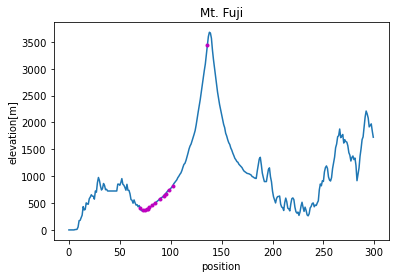

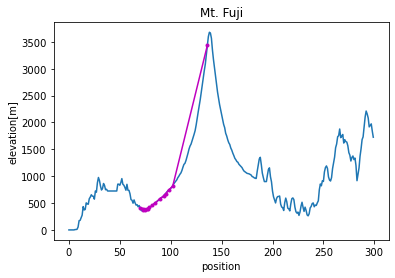

In [7]:
location_x = downhill_mountain(fuji, start_location, learning_rate)
location_y = []
for i in location_x:
    location_y.append(fuji[i,3])

# 点で関数を可視化する
plt.xlabel("position")
plt.ylabel("elevation[m]")
plt.title("Mt. Fuji")
plt.plot(fuji[:,0], fuji[:,3])
plt.plot(location_x, location_y, 'o', color= 'm', markersize=3)
plt.show()

# 線グラフで関数を可視化する
plt.xlabel("position")
plt.ylabel("elevation[m]")
plt.title("Mt. Fuji")
plt.plot(fuji[:,0], fuji[:,3])
plt.plot(location_x, location_y, color= 'm', marker = "o", markersize=3)
plt.show()


### 【問題6】初期値の変更
問題4では最初の「今いる地点」を136としましたが、これを他の全ての点で計算してください。そして、いくつかの初期値に対してどのような下山過程となるか、問題5のように可視化してください。機械学習においては 初期値 をどう設定するかが結果に影響を与えることが確認できます。

**《初期値とは》**
今回の例での最初の地点のような値を初期値と呼びます。これを変更すると結果が変化します。例えば136と142では富士山の異なるの斜面を下ることになります。

In [8]:
# 学習率
learning_rate = 0.2

# すべての地点の移動経路を入れるための配列
all_locations_history = []

# downhill_mountain関数を使用して移動先を計算し、配列に入れる
for i in fuji[:,0]:
    location = int(i)
    downhill = downhill_mountain(fuji, location, learning_rate)
    all_locations_history.append(downhill)
    

# 解答
print("学習率が{}の時、すべての地点からの移動経路は：\n{}"
      .format(learning_rate, all_locations_history))

学習率が0.2の時、すべての地点からの移動経路は：
[[0], [1], [2], [3], [4], [5], [6, 5], [7], [8, 7], [9, 1], [10], [11, 10], [12, 2], [13, 4], [14], [15, 27, 31, 51, 41], [16, 14], [17], [18, 22, 13, 4], [19, 21, 15, 27, 31, 51, 41], [20], [21, 15, 27, 31, 51, 41], [22, 13, 4], [23, 28], [24], [25, 36, 52, 37, 35, 43], [26], [27, 31, 51, 41], [28], [29, 10], [30, 41], [31, 51, 41], [32, 47], [33, 27, 31, 51, 41], [34, 15, 27, 31, 51, 41], [35, 43], [36, 52, 37, 35, 43], [37, 35, 43], [38, 44], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48, 22, 13, 4], [49], [50, 54, 58, 80], [51, 41], [52, 37, 35, 43], [53, 74], [54, 58, 80], [55, 63, 74], [56, 66, 74], [57, 35, 43], [58, 80], [59], [60, 73, 70, 78, 77, 75], [61, 83, 80], [62, 64, 52, 37, 35, 43], [63, 74], [64, 52, 37, 35, 43], [65, 76, 75], [66, 74], [67, 66, 74], [68, 76, 75], [69, 64, 52, 37, 35, 43], [70, 78, 77, 75], [71, 81, 77, 75], [72, 73, 70, 78, 77, 75], [73, 70, 78, 77, 75], [74], [75], [76, 75], [77, 75], [78, 77, 75], [79, 73, 70, 

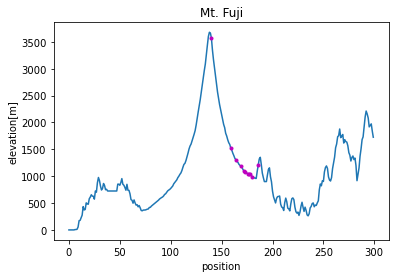

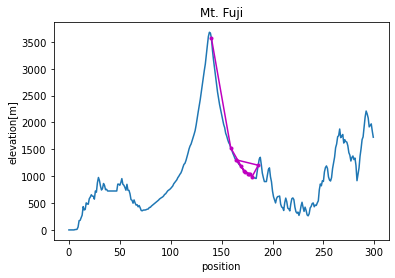

In [9]:
#初期値140の場合

start_location = 140
learning_rate = 0.2

location_x = downhill_mountain(fuji, start_location, learning_rate)
location_y = []
for i in location_x:
    location_y.append(fuji[i,3])
    
# 点で関数を可視化する
plt.xlabel("position")
plt.ylabel("elevation[m]")
plt.title("Mt. Fuji")
plt.plot(fuji[:,0], fuji[:,3])
plt.plot(location_x, location_y, 'o', color= 'm', markersize=3)
plt.show()

# 線グラフで関数を可視化する
plt.xlabel("position")
plt.ylabel("elevation[m]")
plt.title("Mt. Fuji")
plt.plot(fuji[:,0], fuji[:,3])
plt.plot(location_x, location_y, color= 'm', marker = "o", markersize=3)
plt.show()


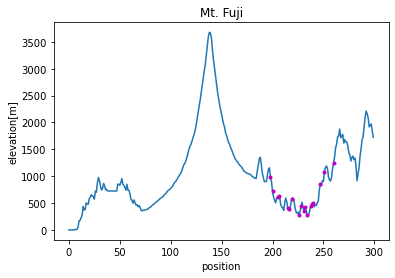

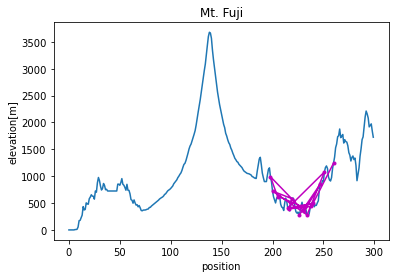

In [10]:
#初期値260の場合

start_location = 260
learning_rate = 0.2

location_x = downhill_mountain(fuji, start_location, learning_rate)
location_y = []
for i in location_x:
    location_y.append(fuji[i,3])
    
# 点で関数を可視化する
plt.xlabel("position")
plt.ylabel("elevation[m]")
plt.title("Mt. Fuji")
plt.plot(fuji[:,0], fuji[:,3])
plt.plot(location_x, location_y, 'o', color= 'm', markersize=3)
plt.show()

# 線グラフで関数を可視化する
plt.xlabel("position")
plt.ylabel("elevation[m]")
plt.title("Mt. Fuji")
plt.plot(fuji[:,0], fuji[:,3])
plt.plot(location_x, location_y, color= 'm', marker = "o", markersize=3)
plt.show()


### 【問題7】（アドバンス問題）ハイパーパラメータの変更
ハイパーパラメータ $\alpha$ を変化させるとどのような下山過程となるか、問題5のように可視化してください。そして、ハイパーパラメータにより結果が大きく異なることを確認してください。


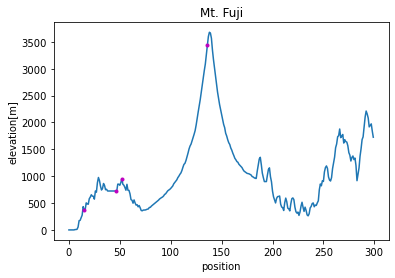

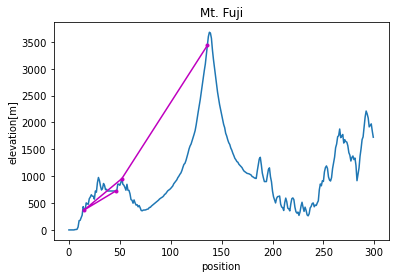

In [11]:
#学習率0.5の場合

start_location = 136
learning_rate = 0.5

location_x = downhill_mountain(fuji, start_location, learning_rate)
location_y = []
for i in location_x:
    location_y.append(fuji[i,3])
    
# 点で関数を可視化する
plt.xlabel("position")
plt.ylabel("elevation[m]")
plt.title("Mt. Fuji")
plt.plot(fuji[:,0], fuji[:,3])
plt.plot(location_x, location_y, 'o', color= 'm', markersize=3)
plt.show()

# 線グラフで関数を可視化する
plt.xlabel("position")
plt.ylabel("elevation[m]")
plt.title("Mt. Fuji")
plt.plot(fuji[:,0], fuji[:,3])
plt.plot(location_x, location_y, color= 'm', marker = "o", markersize=3)
plt.show()